# Random Forests Deep Dive

In this notebook, we do a deep dive into the random forest machine learning model. 



In [1]:
# Imports used in this lesson

import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
from typing import Self

from sklearn.tree import DecisionTreeClassifier as SciKitDecisionTree
from sklearn.datasets import make_classification

# Decision Trees

Random forests are just a collection of many decision trees whose predictions are averaged.
So in order to understand the random forest, we first must understand decision trees.

## Theory

We will first develop the theory for how to use and train a decision tree model.
Once we understand that, then we will use that theory to write the Python code for a `DecisionTree` class.

### How Decision Trees Make Decisions

A decision tree is a very simple process for making any decision.
You simply ask a series of yes/no questions, until you arrive at a termininal point called a "leaf."
The later questions depend on how you answered earlier ones.

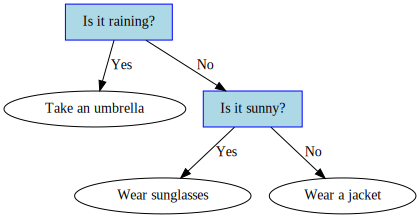

In [2]:
# Example of a basic decision tree

dot = Digraph(comment='Decision Tree Example')

dot.node('A', 'Is it raining?', shape='box', style='filled', fillcolor='lightblue', color='blue')
dot.node('B', 'Take an umbrella', shape='ellipse')
dot.node('C', 'Is it sunny?', shape='box', style='filled', fillcolor='lightblue', color='blue')
dot.node('D', 'Wear sunglasses', shape='ellipse')
dot.node('E', 'Wear a jacket', shape='ellipse')

dot.edge('A', 'B', label='Yes')
dot.edge('A', 'C', label='No')
dot.edge('C', 'D', label='Yes'
        )
dot.edge('C', 'E', label='No')

dot

Let's make use of this same tree for a machine learning model.
We will continue to make use of the decision tree structure, but will replace our yes no questions with questions about a feature.
The most basic question we can ask about a feature is to compare it to some fixed threshold.
We call this the **decision threshold**.

In summary decision tree models

* Ask yes/no questions about one feature at a time
* The feature is compared with a decision threashold
* If the feature is greater than the threshold, move left. Otherwise move right

Suppose we are doing a classification problem where we want to determine if a child with a fever is actually sick.
Two features we could measure are the child's temperature and how long the child has been running a fever.

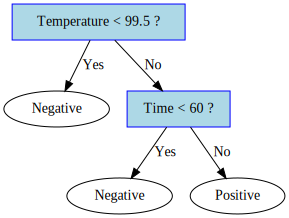

In [3]:
# Example of a decision tree for classification

dot = Digraph(comment='Decision Tree for Classification')

dot.node('A', 'Temperature < 99.5 ?', shape='box', style='filled', fillcolor='lightblue', color='blue')
dot.node('B', 'Negative', shape='ellipse')
dot.node('C', 'Time < 60 ?', shape='box', style='filled', fillcolor='lightblue', color='blue')
dot.node('D', 'Negative', shape='ellipse')
dot.node('E', 'Positive', shape='ellipse')

dot.edge('A', 'B', label='Yes')
dot.edge('A', 'C', label='No')
dot.edge('C', 'D', label='Yes')
dot.edge('C', 'E', label='No')

dot

In this example, a sample with temperature = 100.2 degrees and time = 18 minutes would be classified as negative.

## Choosing the Best Split

Now that we understand how a decision tree can be used to make predictions, let's focus on how we actually train them.
Let's suppose that we are building a _Vampire or Human_ classification algorithm, and we have this basic dataset:

Name|Sunlight Sensitivity|Garlic Tolerance|Is Vampire?
-|-|-|-
Charlie|0.2|1.0|&#x274C;
Vlad|0.8|0.1|&#x2705;
Emile|0.4|0.2|&#x274C;
Francis|0.4|0.5|&#x2705;
AJ|0.9|0.9|&#x274C;

(0.0, 1.1)

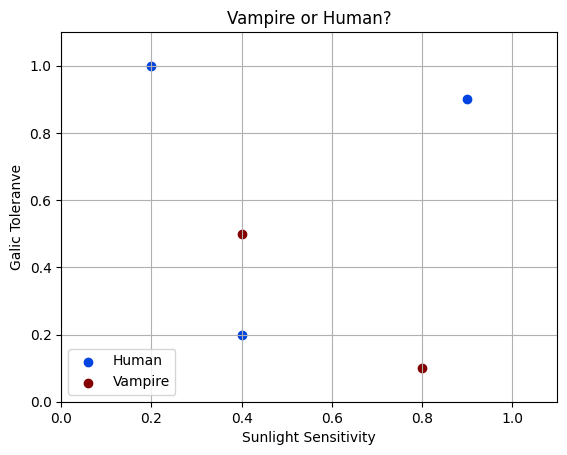

In [4]:
# Also make a plot!

s0 = [.2, .4, .9]
s1 = [.8, .4]
g0 = [1.0, .2, .9]
g1 = [.1, .5]

plt.scatter(s0, g0, color='xkcd:blue', label='Human')
plt.scatter(s1, g1, color='xkcd:dark red', label='Vampire')

plt.grid()
plt.legend(loc='lower left')
plt.title("Vampire or Human?")
plt.xlabel("Sunlight Sensitivity")
plt.ylabel("Galic Toleranve")
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)

Let's make our situation even simpler and decide that we will only create a shallow decision tree with exactly one split and two leaves.
Even with a very tiny dataset, we already have several options for forming our shallow decision tree.

To construct our shallow tree, we only need to select one of the two features, and set a decision threshold.
Now, let's make an observation about this particular dataset. The feature "garlic tolerance" takes on five unique values, while the feature "sunlight sensitivity" takes on only four (since both Emile and Francis have a sensitivity of 0.4).

Why does this matter? Consider these two deicsion trees:

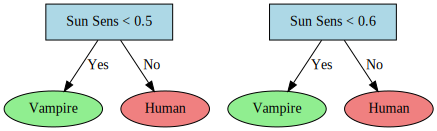

In [5]:
dot = Digraph(comment='Two Identical Trees')

dot.node('A1', 'Sun Sens < 0.5', shape='box', style='filled', fillcolor='lightblue')
dot.node('B1', 'Vampire', shape='ellipse', fillcolor='lightgreen', style='filled')
dot.node('C1', 'Human', shape='ellipse', fillcolor='lightcoral', style='filled')
dot.edge('A1', 'B1', label='Yes')
dot.edge('A1', 'C1', label='No')

dot.node('A2', 'Sun Sens < 0.6', shape='box', style='filled', fillcolor='lightblue')
dot.node('B2', 'Vampire', shape='ellipse', fillcolor='lightgreen', style='filled')
dot.node('C2', 'Human', shape='ellipse', fillcolor='lightcoral', style='filled')
dot.edge('A2', 'B2', label='Yes')
dot.edge('A2', 'C2', label='No')

dot

With respect to our data, these two trees are _identical!_
This is because there are no samples with a sunlight sensitivity between 0.5 and 0.6, so no samples will follow different paths in the two trees.

With this observation made, we can thus consider every possible decision tree for this data and compare them.
We only need to look at each feature and consider enough thresholds to create all possible divisions on that feature.
There are a lot of ways to do this, but a simple one is to take all unique values the feature has and consider averages of consecutive values.

For sunlight sensitivity we have values of 0.2, 0.4, 0.8, and 0.9.
Thus our decision thresholds will be 0.3, 0.6, and 0.85.
For garilc tolerance, our thresholds will be 0.15, 0.35, 0.7, and 0.95.

Note that we always want at least one person in every leaf, so we do not need to consider thresholds which sort the entire dataset into one side of the tree.

We can now draw every possible decision tree!

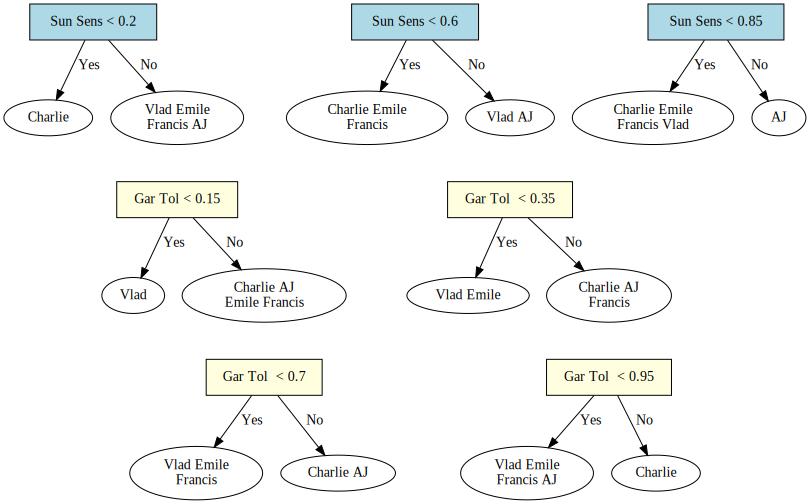

In [6]:
dot = Digraph(comment='Two Identical Trees')

# Sunglight Trees

dot.node('A1', 'Sun Sens < 0.2', shape='box', style='filled', fillcolor='lightblue')
dot.node('B1', 'Charlie', shape='ellipse')
dot.node('C1', 'Vlad Emile\nFrancis AJ', shape='ellipse')
dot.edge('A1', 'B1', label='Yes')
dot.edge('A1', 'C1', label='No')

dot.node('A2', 'Sun Sens < 0.6', shape='box', style='filled', fillcolor='lightblue')
dot.node('B2', 'Charlie Emile\nFrancis', shape='ellipse')
dot.node('C2', 'Vlad AJ', shape='ellipse')
dot.edge('A2', 'B2', label='Yes')
dot.edge('A2', 'C2', label='No')

dot.node('A3', 'Sun Sens < 0.85', shape='box', style='filled', fillcolor='lightblue')
dot.node('B3', 'Charlie Emile\nFrancis Vlad', shape='ellipse')
dot.node('C3', 'AJ', shape='ellipse')
dot.edge('A3', 'B3', label='Yes')
dot.edge('A3', 'C3', label='No')

# Garlic Trees

dot.node('A4', 'Gar Tol < 0.15', shape='box', style='filled', fillcolor='lightyellow')
dot.node('B4', 'Vlad', shape='ellipse')
dot.node('C4', 'Charlie AJ\nEmile Francis', shape='ellipse')
dot.edge('A4', 'B4', label='Yes')
dot.edge('A4', 'C4', label='No')

dot.node('A5', 'Gar Tol  < 0.35', shape='box', style='filled', fillcolor='lightyellow')
dot.node('B5', 'Vlad Emile', shape='ellipse')
dot.node('C5', 'Charlie AJ\nFrancis', shape='ellipse')
dot.edge('A5', 'B5', label='Yes')
dot.edge('A5', 'C5', label='No')

dot.node('A6', 'Gar Tol  < 0.7', shape='box', style='filled', fillcolor='lightyellow')
dot.node('B6', 'Vlad Emile\nFrancis', shape='ellipse')
dot.node('C6', 'Charlie AJ', shape='ellipse')
dot.edge('A6', 'B6', label='Yes')
dot.edge('A6', 'C6', label='No')

dot.node('A7', 'Gar Tol  < 0.95', shape='box', style='filled', fillcolor='lightyellow')
dot.node('B7', 'Vlad Emile\nFrancis AJ', shape='ellipse')
dot.node('C7', 'Charlie', shape='ellipse')
dot.edge('A7', 'B7', label='Yes')
dot.edge('A7', 'C7', label='No')


# Invisible connections to create layers
dot.edge('C1', 'A4', style='invis')
dot.edge('C2', 'A5', style='invis')
dot.edge('C4', 'A6', style='invis')
dot.edge('C5', 'A7', style='invis')

dot

Now that we have every possible tree, we just need a way to objectively compare them all to pick the best one.
What we want is a split which _maximally divides the two classes_.
If we consider the percentage of vampires in the "yes" group with those in the "no" group, the best option is a split where we have a large percentage in one and a low percentage in the other.

> **Note:** Here "yes" and "no" refer to the answer to the splitting question, not whether or not the person is a vampire!

Tree Number|Feature|Threshold|Yes % Vampire|No % Vampire
-|-|-|-|-
1|Sunlight Sensitivity|0.2|0%|50%
2|Sunlight Sensitivity|0.6|30%|50%
3|Sunlight Sensitivity|0.85|50%|0%
4|Garlic Tolerance|0.15|100%|75%
5|Garlic Tolerance|0.35|50%|33%
6|Garlic Tolerance|0.7|67%|0%
7|Garlic Tolerance|0.95|50%|0%

Looking at the table, it would appear that tree number 6 is a good option.
But how can we be sure?
We need an objective metric we can compute for each tree.

### The Gini Information Index

The truth is that there are many possible ways we can evaluate different decision tree splits to pick the best one.
A common choice is the _Gini information index_.

> **The Idea**
>
> _Given a collection of objects of various types, what is the probability that you would **incorrectly** guess the type of a randomly chosen object correctly if you were to guess randomly?_

Let's work through an example and then write down the formula.

#### Example

Suppose we have a jar which contains marbles of two colors: gold and turquoise.
The jar contains two gold marbles and thee turquoise ones.
Let's calculate some probabilities:

Event | Probaility
-|-
Choose Gold | $2 / 5 = 40\%$
Choose Turquoise | $3 / 5 = 60\%$

Now, it's important to look carefully at the question we are trying to ask here.
There are actually _two_ random events happening.

1. We are choosing a marble randomly.
2. We are guessing a color randomly.

Both of these random events are with respect to the probalities which we listed above.
We will use two facts about probability to calculate the answer to our question.
First, we will use the fact that the probabilty of two independent events both occurring is the product of their individual probabilities.
Which marble we pick and which color we guess are independent, so we can write

$$P(\text{Guess Gold and Pick Gold}) = P(\text{Guess Gold}) \cdot P(\text{Pick Gold})$$
$$P(\text{Guess Turquoise and Pick Turquoise}) = P(\text{Guess Turquoise}) \cdot P(\text{Pick Turquoise})$$
We know that for either color, the probability of guessing and picking are the same, so we can write this out:

$$P(\text{Guess Gold and Pick Gold}) = \left(\frac{2}{5}\right)^2 = \frac{4}{25} = 0.16$$
$$P(\text{Guess Turquoise and Pick Turquoise}) = \left(\frac{3}{5}\right)^2 = \frac{9}{25} = 0.36$$

For independent, mutually exclusive events, the probabilty of either occurring is the sum of their individual probalities.
Picking gold and picking turquoise cannot happen at the same time, so we can now write

$$P(\text{Guess Correctly}) = P(\text{Guess Gold and Pick Gold}) +
P(\text{Guess Turquoise and Pick Turquoise})$$
$$P(\text{Guess Correctly}) = 0.16 + .36 = .52.$$

Lastly, to compute the Gini index, we want the probabity that we guessed _wrong_.
This is simply one minus the probability we guessed correctly.

$$P(\text{Guess Incorrectly}) = 1 - P(\text{Guess Correctly}) = 1 - .52 = .48$$

Thus our Gini index for this situation was .48.

---

We can simplify the formula we just wrote down by noticing since we only have two outcomes possible, the probability we pick turquoice is equal to one minus the probability we pick gold.
More generally, if $p$ is the proportion of the positive class in a collection of two classes, then
$$\text{Gini} = 1 - p^2 - (1 - p)^2$$
$$= 1 - p^2 - (1 - 2p + p^2)$$
$$= 1 - p^2 - 1 + 2p - p^2$$
$$=2p - 2p^2$$
$$=2p(1 - p)$$

This formula is actually just a simple parabola which crosses the y-axis at zero and one, and has a maximim at $p = 1/2$.
This is _exactly_ what we want! It assigns a low value when a contanier has mostly all the same kind of object, and a high value when there is an even split.

> Now, I know what you are thinking. I could have just told you this formula at the beginning of this section and saves us a lot of time.
> But by working this out starting with what we want, hopefully the _why_ of the formula makes a lot more sense.

Text(0, 0.5, 'Gini')

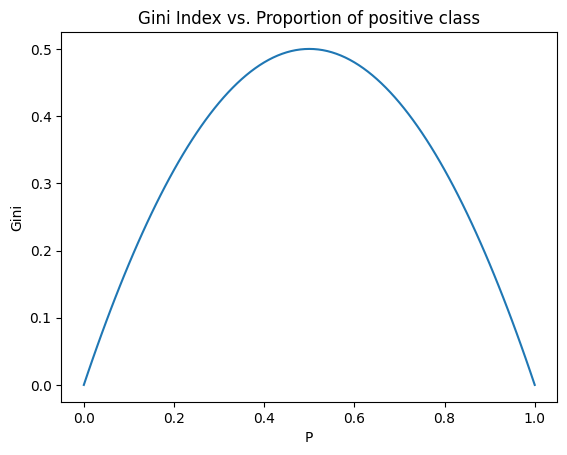

In [7]:
p = np.linspace(0, 1, 101)

y = 2 * p * (1 - p)

plt.plot(p, y)

plt.title("Gini Index vs. Proportion of positive class")
plt.xlabel("P")
plt.ylabel("Gini")

Now that we understand the Gini index, we are ready to formally evalute our vampire decection models.
Since each tree creates two leaves (yes and no), we could sum the Gini index for both leaves to get the Gini index for the tree:

$$\text{Gini}_{Tree} = \text{Gini}_{yes} + \text{Gini}_{no}$$

This is not what we actually do though.
Instead we take one other thing into account.
Namely, _splits with more samples should count more!_
Thus, we actually compute a _weighted_ sum instead.

$$\text{Gini}_{Tree} = \frac{\text{size yes}}{\text{total}} \cdot \text{Gini}_{yes} + 
\frac{\text{size no}}{\text{total}} \cdot \text{Gini}_{no}$$

For example, let's calculate the Gini information for the tree which splits on sunlight sensitivity with threshold = 0.6.

$$\text{Gini}_{Tree} = \frac{3}{5}\cdot 2(.33)(1 - .33) + \frac{2}{5}\cdot 2(0.5)(1 - 0.5) = 0.47$$

We can now do this for all the trees, adding a column to our table from before:

Tree Number|Feature|Threshold|Yes % Vampire|No % Vampire|Gini
-|-|-|-|-|-
1|Sunlight Sensitivity|0.2|0%|50%|.40
2|Sunlight Sensitivity|0.6|30%|50%|.47
3|Sunlight Sensitivity|0.85|50%|0%|.40
4|Garlic Tolerance|0.15|100%|75%|.30
5|Garlic Tolerance|0.35|50%|33%|.47
6|Garlic Tolerance|0.7|67%|0%|.27
7|Garlic Tolerance|0.95|50%|0%|.40

Nice! Looks like our initial intuition about tree number 6 was correct!

### Growing Larger Trees

We now have all the pieces in place to build our decision tree!
To create trees with more than one split, we only need to recursively generate splits.

> **Decision Tree Training Algorithm**
>
> 1. For each feature in your dataset, consider every possible split which would divide the data.
> 2. For each feature/split duo, compute the Gini information index for the yes and no leaves.
> 3. Compute the sum of the Gini indexes, weighted by the size of the split. 
> 4. Select the split which results in the smallest sum.
> 5. If we have yet not reached our stopping criteria, then repeat steps 1-3 for both leaves, using only the data that would end up in that split.

There are lots of options for stopping critera. Popular choices are either limiting the depth of the tree, or requiring a minimun number of samples in a leaf. In our example, we will use the leaf size criteria, because it will be easy to implement.


> **Decision Tree Prediction**
> 
> 1. For every sample you wish to classify, move down the decision tree until you arive at a leaf.
> 2. Classify the sample as whatever class is the majority of that leaf.

## Code

With the theory established, we will now implement a `DecisionTree` class.
The code will be optimized for _readability, clarity, and understandability_.
In service of this end, we will be overly verbose in our code practice.
There are definitly some computational optimizations which we could do, but that is not our goal for this lesson.

We will first build out the code for a decision tree which can make predictions.
We will then implement the code for training such a tree using some training data.

### Prediction

The prediction code will be fairly straightforward.
We want need a class which represents the nodes of the tree, and a class for the tree itself.

In [8]:
class TreeNode:
    """
    This class defines one of the nodes of our tree.
    We will then build our tree out of these nodes.
    Nodes are either decision nodes, or leaves.

    :attr probability: The proportion of the data in this node which is of the positive class.
    :attr is_leaf: True if the node represents a leaf, False if the node represents a decision node.
    :attr threshold: Decision threshold for decision nodes.
    :attr column_idx: Index of the column which contains the data we are splitting on.
    """

    def __init__(
        self, 
        probability: float,
        is_leaf: bool = True,
        threshold: float | None = None,
        column_idx: int | None = None,
    ):
        self.probability = probability
        self.is_leaf = is_leaf
        self.threshold = threshold
        self.column_idx = column_idx

        # The children nodes
        self.right: Self | None = None
        self.left: Self | None = None

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Use this node to create a list of predictions.

        :param X: The featrue matrix:

        :returns: An array of the predictions.
        """

        # If this node is a leaf, then we assign assign all elements the same class.
        if self.is_leaf:
            if self.probability < 0.5:
                return np.zeros_like(X[:, 0])
            else:
                return np.ones_like(X[:, 0])

        # We have a decision to make.
        # In this case, we are depending on this node having a left right child nodes.
        # It's a good idea to assert to doublecheck that those were in fact defined.
        assert self.left is not None and self.right is not None, "This decision node does not have children."

        # Divide the data into left and right splits
        splitting_feature = X[:, self.column_idx]

        left_split_idx = splitting_feature < self.threshold
        right_split_idx = splitting_feature >= self.threshold
        
        left_X = X[left_split_idx]
        right_X = X[right_split_idx]

        # Recursively make predictions on each side
        left_result = self.left.predict(left_X)
        right_result = self.right.predict(right_X)
        
        # Combine the predictions into one vector
        final_result = np.zeros_like(X[:, 0])

        # assert final_result.size > 0
        
        final_result[left_split_idx] = left_result
        final_result[right_split_idx] = right_result

        return final_result
        


### TEST ###

test_X = np.array([
    [1, 20],
    [2, 10],
    [3, 15],
])

print("Test 1 - Leaf Node")
print("This should print [0 0 0]")

node = TreeNode(0.4, is_leaf=True)

print(node.predict(test_X))

print('-' * 25)
print("Test 2 - Shallow Tree")
print("This should print [0, 1, 0]")

node = TreeNode(0.5, is_leaf=False, threshold=12, column_idx=1)
node.right = TreeNode(0.0, is_leaf=True) # Alway negative
node.left = TreeNode(1.0, is_leaf=True)  # Always positive

print(node.predict(test_X))

Test 1 - Leaf Node
This should print [0 0 0]
[0 0 0]
-------------------------
Test 2 - Shallow Tree
This should print [0, 1, 0]
[0 1 0]


### Training

Before we write the completed `DecisionTree` class, we need to talk about training.

For training, we have a few helper functions which will be useful.

* Functions to help us compute the Gini index
* Functions to generate candidate splits

Of course, the most important is computing the Gini index for splits.

In [9]:
# Helper functions to compute Gini

def gini(p: float) -> float:
    """Calculate Gini for a given probability of positive class.
    
    :param p: The probability

    :returns: The Gini index.
    """
    return 2 * p * (1 - p)


def gini_for_split(
    left_positive: int, 
    left_negative: int, 
    right_positive: int, 
    right_negative: int
) -> float:
    """Calculate the weighted Gini sum for a given splitting result.
    
    :param left_positive: The count of positive class samples in the left split
    :param left_negative: The count of negative class samples in the left split
    :param right_positive: The count of positive class samples in the right split
    :param right_negative: The count of negative class samples in the right split

    :returns: The computed Gini index sum.
    """

    # Compute counts
    size_left = left_positive + left_negative
    size_right = right_positive + right_negative
    total = size_left + size_right

    # Get the Gini
    gini_left = gini(left_positive / size_left)
    gini_right = gini(right_positive / size_right)

    # Return the weighted sum
    return (size_left * gini_left + size_right * gini_right) / total


def gini_from_arrays(x: np.ndarray, y: np.ndarray, threshold: float) -> float:
    """Compute the Gini sum given some input data.

    :param x: Array that contains the feature we are using to decide the split.
    :param y: Array that contains the class labels. Assume all 0 and 1. Same size as x.
    :param threshold: The decision threshold.

    :return: The computed Gini index for this decision threshold on this feature.
    """

    # Get the elements in each split
    # Note that we do have to make a decision about what to do in cases where x == threshold.
    left_split = y[x < threshold]
    right_split = y[x >= threshold]  # == goes in the right side.

    # Compute counts
    left_positive = (left_split == 1).sum()
    left_negative = (left_split == 0).sum()
    right_positive = (right_split == 1).sum()
    right_negative = (right_split == 0).sum()

    # Use our helper function to compute the weighted sum
    return gini_for_split(left_positive, left_negative, right_positive, right_negative)


### TEST ###

# Check our work using the vampire data from above
sunlight_sens = np.array([.2, .8, .4, .4, .9])
is_vampire = np.array([0, 1, 0, 1, 0])

# Should return .466...
gini_from_arrays(sunlight_sens, is_vampire, 0.6)

0.4666666666666667

Another helper we will need is the function which generates the candidate splits.

In [10]:
def get_candidate_decision_thresholds(x: np.ndarray) -> np.ndarray:
    """Compute the options for splitting thresholds given an array of feature values.

    :param x: The data for the feature we are generating splits for.

    :returns: An array of splits.
    """
    unique_values_sorted = np.sort(np.unique(x))

    # We need to handle the case where there is only one unique value in the array.
    # In that case, we have no candidate splits so return an empty array

    if unique_values_sorted.size == 1:
        return np.array([], dtype=float)

    # Average the consecutive values.
    # We know there are at least 2 elements in the array becasuse of the if statement above,
    # so no indexing error is possible here.
    return (unique_values_sorted[:-1] + unique_values_sorted[1:]) / 2


### TEST ###

arr = np.array([10, 4, 3, 4, 5, 1])

# Should return [2, 3.5, 4.5, 7.5])
get_candidate_decision_thresholds(arr)

array([2. , 3.5, 4.5, 7.5])

We can now use this function to get the _best_ split.

In [12]:
def get_best_split(X: np.ndarray, y: np.ndarray, min_samples_leaf: int = 2) -> tuple[float, int]:
    """Evaluate all possible decision thresholds for all columns and return the best one

    :param X: The feature matrix
    :param y: The target vector
    :param min_samples_leaf: Reject splits which result in children with fewer than this number of elements.

    :returns: Tuple containing decision threshold and column index.
    """

    lowest_gini = 2.0 # Gini is bounded above by 1
    best_idx = 0
    best_threshold = 0.0
    
    # Loop over all columns of X
    for idx in range(X.shape[1]):
        candidate_thresholds = get_candidate_decision_thresholds(X[:, idx])

        if min_samples_leaf > 1:
            # We now will reject any thresholds which result in splits
            # giving fewer than min_samples_leaf samples.
            candidate_thresholds = candidate_thresholds[min_samples_leaf - 1: -min_samples_leaf+1]

        # Loop over all thresholds
        for t in candidate_thresholds:
            this_gini = gini_from_arrays(X[:, idx], y, t)
            
            if this_gini < lowest_gini:
                # We found a better option
                best_threshold = t
                best_idx = idx
                lowest_gini = this_gini

    return best_threshold, best_idx

### TEST

# Use the whole vampire dataset

X = np.array([
    [0.2, 1.0],
    [0.8, 0.1],
    [0.4, 0.2],
    [0.4, 0.5],
    [0.9, 0.9],
])

y = np.array([0, 1, 0, 1, 0])

# We found above by hand that this should return (0.7, 1)
get_best_split(X, y)

(0.7, 1)

We are so close!
We only need now to recursively build out our tree.

In [13]:
def recursive_create_tree_nodes(X: np.ndarray, y: np.ndarray, min_samples_leaf: int = 2) -> TreeNode:
    """Given a feature matrix and target vector, recursively create tree nodes.

    Find the best possible split for this data set.
    
    If the best split would result in leaves with fewer than min_samples_leaf samples,
    then make this a leaf instead.

    :param X: The feature matrix.
    :param y: The target vector.
    :param min_samples_leaf: Do not genereate leaves smaller than this.

    :returns: The generated TreeNode.
    """

    # If the whole dataset has all the same kind of element, this can be a leaf
    probability = (y == 1).mean()

    if probability == 0.0 or probability == 1.0:
        return TreeNode(probability=probability, is_leaf=True)
    
    # If X has fewer than 2 * min_samples_leaf rows, then NO split will result in valid leaves
    # so we can bail out now.
    if X.shape[0] < 2 * min_samples_leaf:
        return TreeNode(probability=probability, is_leaf=True)
    
    # Otherwise, there _might_ be valid splits.
    threshold, column_idx = get_best_split(X, y, min_samples_leaf=min_samples_leaf)
    
    # Check to make sure that the child leaves will not be too large
    # (Make sure that we put the "or equal to" on the same side as in our TreeNode class!)
    
    left_idx = (X[:, column_idx] < threshold)
    right_idx = (X[:, column_idx] >= threshold)
    left_size = left_idx.sum()
    right_size = right_idx.sum()
    
    if left_size < min_samples_leaf or right_size < min_samples_leaf:
        return TreeNode(probability=probability, is_leaf=True)

    # The split is valid

    tree_node = TreeNode(
        probability=probability, 
        is_leaf=False, 
        column_idx=column_idx, 
        threshold=threshold
    )

    # Get this node's children
    left_X, left_y = X[left_idx], y[left_idx]
    right_X, right_y = X[right_idx], y[right_idx]

    # Do our recursion
    left_node = recursive_create_tree_nodes(left_X, left_y, min_samples_leaf)
    right_node = recursive_create_tree_nodes(right_X, right_y, min_samples_leaf)

    # Assign the new nodes to left/right children
    tree_node.left = left_node
    tree_node.right = right_node

    return tree_node


### TEST

# Setting min_samples_leaf=1 means we should overfit and get perfect predictions
node = recursive_create_tree_nodes(X, y, min_samples_leaf=1)

# Should be [0, 1, 0, 1, 0]
node.predict(X)

array([0., 1., 0., 1., 0.])

Since we wrote so many helper functions, our `DecisionTree` class itself is rather simple.

In [14]:
class DecisionTree:
    """A decision tree model."""

    def __init__(self, min_samples_leaf: int = 2):
        """Create a new DecisionTree object

        :param min_samples_leaf: Do not create leaves with fewer than this number of training samples.
        """
        self.min_samples_leaf = min_samples_leaf

        self.root: TreeNode | None = None

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make a prediction

        :param X: The data we are predicting on.

        :returns: Array of predictions
        """
        # Simple enough, we just use the root node's predict function.

        assert self.root is not None, "This decision tree is not fit yet!"
        
        return self.root.predict(X)

    def fit(self, X: np.ndarray, y: np.ndarray) -> Self:
        """Train the model
        
        :param X: The feature matrix we are trainign on.
        :param y: The target vector."""
        
        self.root = recursive_create_tree_nodes(X, y, self.min_samples_leaf)

        # Follow sklearn style and have the fit function return itself.
        return self

This concludes the creation of our decision tree class!
Let's compare it with the one Scikit Learn provides

In [27]:
X, y = make_classification()

We'll use the `%%time` magic function to see how much more optimized Scikit's version is than ours.

In [28]:
%%time

my_dt = DecisionTree()

my_dt.fit(X, y)

CPU times: user 95.9 ms, sys: 3.62 ms, total: 99.5 ms
Wall time: 96.3 ms


In [29]:
%%time

sk_dt = SciKitDecisionTree(min_samples_leaf=2)

sk_dt.fit(X, y)

CPU times: user 4.77 ms, sys: 408 μs, total: 5.18 ms
Wall time: 4.15 ms


DecisionTreeClassifier(min_samples_leaf=2)

In [31]:
agree = my_dt.predict(X) == sk_dt.predict(X)

# Print precentage of agreement.
# Multiple tests show that this is between 94% and 100%.

agree.mean()

0.98

This is awesome!
We ended up with predictions very similar to the `sklearn.tree.DecisionTreeClassifier` class!
Pretty cool!

# Random Forests